# Clustering Yelp Restaurants

**Part 2: To be completed INDIVIDUALLY and due on October 21 at 7pm.**

In this assignment, we will continue to work with the [Yelp dataset](https://drive.google.com/open?id=0B4bdB5WPHGsqcmJMNmxzQmQ3aTQ) that we used in Homework 2-1.

We will continue to try to find culinary districts in Las Vegas. 

(As a reminder from last time, these are characterized by closeness and similarity of restaurants. Use the "longitude" and "latitude" to cluster closeness.)

However, in this analysis we will not use the Yelp-supplied "categories" to cluster for similarity as we did in Part 1.

Instead we will cluster the reviews themselves, extracting categories in an unsupervised fashion.  

Specifically, you are to use Latent Semantic Analysis (LSA) on the Yelp reviews to cluster restaurants based off on their reviews.  As a reminder, LSA consists of using PCA applied to the document-term matrix.

LSA was covered in lecture, and there is another tutorial [here.](http://www.datascienceassn.org/sites/default/files/users/user1/lsa_presentation_final.pdf
)

**(20 pts)**

In [154]:
import pandas as pd
import json
from pandas import DataFrame
import numpy as np
data = []
for line in open('yelp_academic_dataset_business.json', 'r'):
    data.append(json.loads(line))
df = DataFrame(data)
df = df[df['city'] == 'Las Vegas'][['business_id','categories', 'latitude', 'longitude']]
df['categories'] = df['categories'].apply(lambda x: ', '.join(x))
df = df[df['categories'].str.contains('restaurant', case = False)]
df_similarity = df['categories']
df_closeness = df[['latitude', 'longitude']]
valid_bid = df['business_id'].values.tolist()

In [3]:
#'yelp_academic_dataset_review.json'
data2 = {}
with open('yelp_academic_dataset_review.json', 'r') as f:
    for line in f:
        d = json.loads(line)
        bid = d['business_id']
        text = d['text']
        if bid in valid_bid:
            data2.setdefault(bid,[]).append(d['text'])

In [4]:
#select a subset of reviews to try
# for key in data2:
#     if len(data2[key]) > 3:
#         data2[key] = data2[key][:2]

In [4]:
data3 = {k: v for k, v in data2.items() if v}
df2 = DataFrame(list(data2.items()),columns = ['business_id', 'text'])
ls = df2['text'].values.tolist()
for i in range(len(ls)):
    ls[i] = ', '.join(ls[i]).replace('\n',' ')

In [5]:
df2['text'] = ls

In [6]:
df3 = pd.merge(df,df2,on='business_id')[['latitude','longitude','text']]
review = df3['text'].values.tolist()
len(review)

4658

In [8]:
#stemming
# from nltk.stem.snowball import SnowballStemmer
# from nltk.tokenize import word_tokenize, sent_tokenize


# stemmed_data = [" ".join(SnowballStemmer("english", ignore_stopwords=True).stem(word)  
#          for sent in sent_tokenize(message)
#         for word in word_tokenize(sent))
#         for message in review]

In [9]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
vectorizer = TfidfVectorizer(min_df = 0.01, stop_words = 'english', max_df = 0.95)
dtm = vectorizer.fit_transform(review)
dtm.shape

(4658, 13065)

In [10]:
dtm_dense = dtm.todense()
centered_dtm = dtm_dense - np.mean(dtm_dense, axis=0)
np.sum(centered_dtm,axis=0)[:,:10]

matrix([[ -9.87057658e-14,  -1.46472461e-14,   9.91231836e-15,
          -2.13357977e-14,   3.04254235e-15,  -1.29380014e-14,
           1.14209857e-15,  -1.03071848e-14,  -4.52730301e-15,
          -1.00015482e-14]])

In [11]:
u,s,vt = np.linalg.svd(centered_dtm)

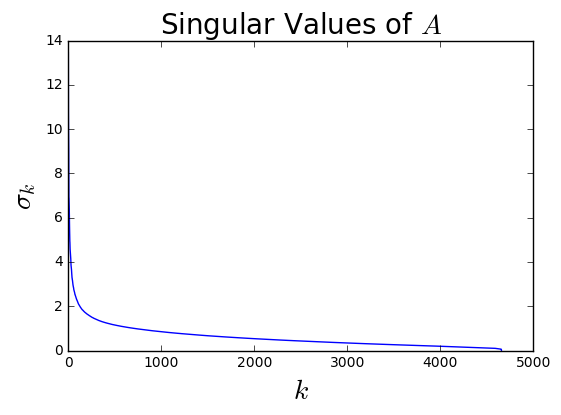

In [12]:
import matplotlib.pyplot as plt
%matplotlib inline
fig = plt.figure(figsize=(6,4))
plt.plot(range(1,len(s)+1),s)
plt.xlabel(r'$k$',size=20)
plt.ylabel(r'$\sigma_k$',size=20)
_ = plt.title(r'Singular Values of $A$',size=20)

In [13]:
#use k = 100 for SVD because after k = 100 the decrease of sigma is not significant
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import Normalizer
lsa = TruncatedSVD(100, algorithm = 'randomized')
dtm_lsa = lsa.fit_transform(dtm)
dtm_lsa = Normalizer(copy=False).fit_transform(dtm_lsa)

In [14]:
Vt = pd.DataFrame(lsa.components_,columns = vectorizer.get_feature_names())#how 'concepts' are constructed by terms

In [15]:
U_sigma = pd.DataFrame(dtm_lsa) #each column represents a 'concept', which is a combination of term feature in dtm

In [16]:
#for every concept in U, generate the most important 20 terms
labels = []
for i in range(100):
    labels.append(Vt.loc[i].nlargest(10))
labels

[great      0.189001
 service    0.184635
 like       0.180298
 just       0.169852
 pizza      0.159098
 time       0.140589
 chicken    0.134244
 really     0.124696
 order      0.124393
 ordered    0.123728
 Name: 0, dtype: float64, pizza        0.902232
 crust        0.116548
 delivery     0.095433
 pizzas       0.093496
 wings        0.079333
 pepperoni    0.075876
 slice        0.056778
 toppings     0.050733
 cheese       0.050285
 hut          0.049929
 Name: 1, dtype: float64, sushi       0.552006
 rolls       0.149260
 roll        0.141708
 thai        0.116676
 ayce        0.097110
 chinese     0.096772
 soup        0.074107
 japanese    0.073266
 rice        0.068964
 sashimi     0.067608
 Name: 2, dtype: float64, sushi      0.370354
 tacos      0.322508
 taco       0.235531
 mexican    0.227117
 burrito    0.208258
 asada      0.183522
 rice       0.168638
 carne      0.158762
 salsa      0.158295
 pizza      0.143697
 Name: 3, dtype: float64, thai       0.402507
 chinese 

In [17]:
from sklearn.preprocessing import MinMaxScaler
scale =  MinMaxScaler()
df_closeness = DataFrame(scale.fit_transform(df_closeness.as_matrix()))
df_feature = U_sigma
df_feature[['latitude', 'longitude']] = df_closeness
df_feature.shape[1] #conbine closeness and similarity after scaling

102

Find clusters using the 3 different techniques we discussed in class: k-means++, hierarchical, and GMM. Visualize the clusters by plotting the longitude/latitude of the restaurants in a scatter plot and label each cluster. 

Note that to label each cluster, you will need to think about how to extract labels from the LSA results.
**(25 pts)**

In [18]:
#adjust the scale for closeness and similarity
def scale_dataframe(df, a): 
    df_sparse = df.ix[:,:-2]
    df_new = df.ix[:,-2:].apply(lambda x: a*x) 
    return pd.concat([df_sparse,df_new], axis = 1)

In [19]:
def get_cluster(cluster, df): 
    d = {}
    i = 0
    cluster = cluster.tolist()
    while i < len(cluster):
        if cluster[i] in d:
            d[cluster[i]].append(df.loc[i,].values)
        else:
            d[cluster[i]] = []
            d[cluster[i]].append(df.loc[i,].values)
        i = i+1
    return d

In [20]:
#find the in-cluster mean of each feature
def get_center(single_cluster):
    i = 0
    result = []    
    while i < df_feature.shape[1]:
        result.append(sum([single_cluster[x][i] for x in range(len(single_cluster))])/len(single_cluster))
        i = i + 1
    return result

In [21]:
#Kmeans clustering
from sklearn.cluster import KMeans  
import sklearn.metrics as metrics
def sc_evaluate_clusters(X,max_clusters):
    s = np.zeros(max_clusters+1)
    s[0] = 0;
    s[1] = 0;
    for k in range(2,max_clusters+1):
        kmeans = KMeans(init='k-means++', n_clusters=k, n_init=10)
        kmeans.fit_predict(X)
        s[k] = metrics.silhouette_score(X,kmeans.labels_,metric='cosine')
    plt.plot(range(2,len(s)),s[2:])
    plt.xlabel('Number of clusters')
    plt.ylabel('Adjusted Rand Index')
    plt.show()

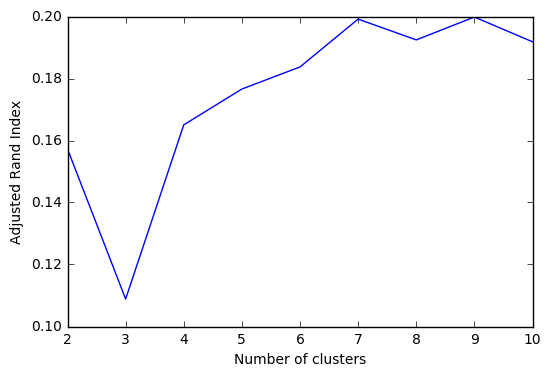

In [22]:
sc_evaluate_clusters(df_feature, 10)
#Notice that the slope decrease after cluster 7, so I choose the number of clusters for K-mean as 7

In [178]:
k=7
kmeans = KMeans(n_clusters=k, init='k-means++', max_iter=100, n_init=1)
kmeans_cluster = kmeans.fit_predict(df_feature)
kmeans_predict = kmeans.predict(df_feature)
kmeans_cluster

array([4, 0, 1, ..., 4, 3, 4])

In [95]:
kcluster = get_cluster(kmeans_cluster, df_feature)
klocation = {}
for i in range(k):
    klocation[i] = []
    for j in range(len(kcluster[i])):
        klocation[i].append((kcluster[i][j][-1],kcluster[i][j][-2]))

In [96]:
klocation[1][1] == (kcluster[1][1][-1],kcluster[1][1][-2])

True

In [30]:
kcenter = []
for i in range(k):
    kcenter.append(get_center(kcluster[i])[:100])
    kcenter[i] = np.array(kcenter[i]).argsort()[::-1]
for i in range(k):
    print("Cluster {}:".format(i))
    for j in kcenter[i][1:5]:
        print (' {}'.format(labels[j].index.tolist()))

Cluster 0:
 ['burger', 'fries', 'sushi', 'sandwich', 'order', 'burgers', 'subway', 'drive', 'chicken', 'location']
 ['bbq', 'chicken', 'ribs', 'brisket', 'korean', 'mac', 'pho', 'hawaiian', 'wings', 'katsu']
 ['dog', 'taco', 'dogs', 'hot', 'tacos', 'fries', 'chicago', 'gyro', 'wings', 'del']
 ['ramen', 'subway', 'wings', 'filipino', 'asada', 'carne', 'roberto', 'crab', 'pork', 'halo']
Cluster 1:
 ['great', 'service', 'like', 'just', 'pizza', 'time', 'chicken', 'really', 'order', 'ordered']
 ['sushi', 'tacos', 'taco', 'mexican', 'burrito', 'asada', 'rice', 'carne', 'salsa', 'pizza']
 ['sushi', 'rolls', 'roll', 'thai', 'ayce', 'chinese', 'soup', 'japanese', 'rice', 'sashimi']
 ['breakfast', 'thai', 'buffet', 'eggs', 'pancakes', 'coffee', 'pad', 'curry', 'hash', 'toast']
Cluster 2:
 ['sushi', 'tacos', 'taco', 'mexican', 'burrito', 'asada', 'rice', 'carne', 'salsa', 'pizza']
 ['dog', 'dogs', 'mexican', 'salsa', 'hot', 'chips', 'chili', 'chicago', 'enchiladas', 'margaritas']
 ['indian', 'ch

Cluster 0 are typical american food like burger, fries, chicken, wings, hot dogs...could be fast food restaurant or grill bar.
Cluster 1 are Japanese food because sushi, japanese and sashimi appear together. There are also mexican restaurants
Cluster 2 are mexican food because mexican, taco, burroto, carne asada come together
Cluster 3 are restaurants for breakfast. Eggs, pancakes, toast soup coffee come together.
Cluster 4 are Korean restaurants. ramen, kimchi, bulgogi are korean food. 
Cluster 5 are bars since bar, beer, burger, wings, fries come together.
Cluster 6 are Asian food because Chinese, Japanese and Thai food appear together in this chuster.  

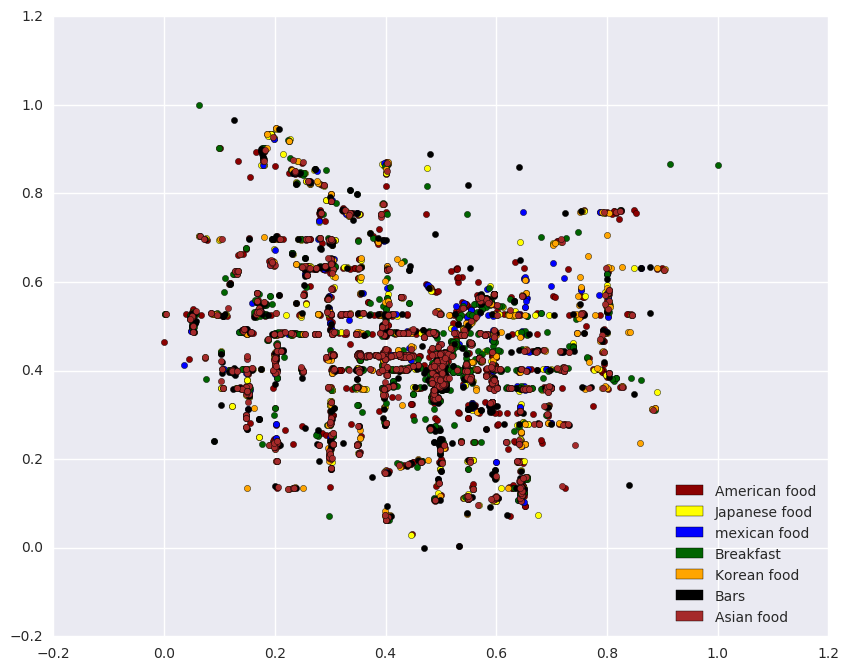

In [150]:
import matplotlib.patches as mpatches
#plot kmeans_cluster
kcolors = ['darkred','yellow','blue','darkgreen','orange','black','brown']
kclasses = ['American food', 'Japanese food', 'mexican food', 'Breakfast', 'Korean food', 'Bars', 'Asian food']
plt.figure(figsize=(10, 8))
plt.figure(figsize=(10, 8))
for j in range(len(klocation.keys())): 
    plt.scatter([i[0] for i in klocation[j]],[i[1] for i in klocation[j]], marker = 'o', c = kcolors[j])
kcircles = []
for i in range(0,len(kcolors)):
    kcircles.append(mpatches.Circle((0,0),1,fc=kcolors[i]))
plt.legend(kcircles,kclasses,loc=4)
plt.show()

In [49]:
#hierarchical clustering. Use ward distance after I try many options. 
#because it gives less chains and less suspectible with outliers  
from scipy.cluster.hierarchy import dendrogram, linkage
Z = linkage(df_feature, 'ward')

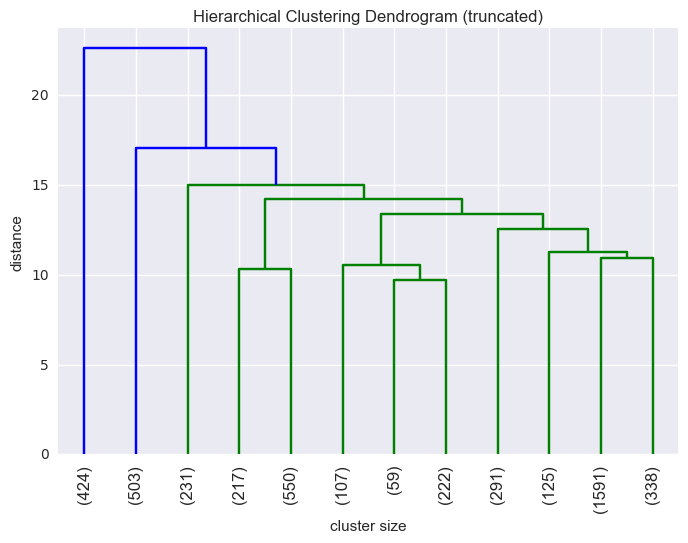

In [86]:
#dendrogram
plt.title('Hierarchical Clustering Dendrogram (truncated)')
plt.xlabel('cluster size')
plt.ylabel('distance')
dendrogram(
    Z,
    truncate_mode='lastp',  # show only the last p merged clusters
    p=12,  # show only the last p merged clusters
    show_leaf_counts=True,  # otherwise numbers in brackets are counts
    leaf_rotation=90.,
    leaf_font_size=12.,
    show_contracted=False,  
)
plt.show()

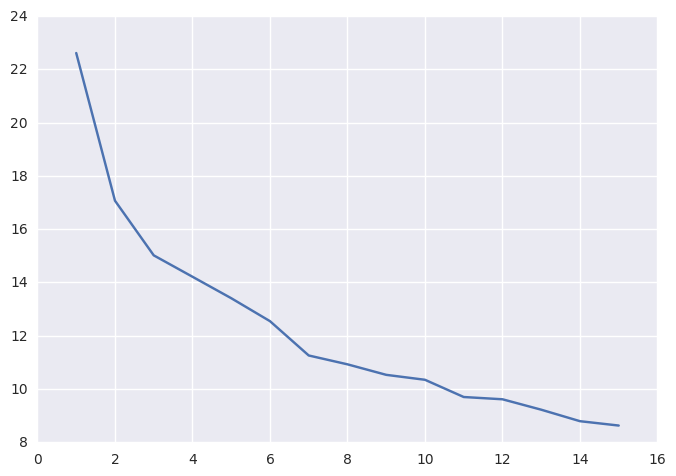

In [87]:
#elbow method for hierarchical clustering to choose k, show k = 7
last = Z[-15:, 2]
last_rev = last[::-1]
idxs = np.arange(1, len(last) + 1)
plt.plot(idxs, last_rev)
plt.show()

In [129]:
from scipy.cluster.hierarchy import fcluster
h=7
hierarchy_cluster = fcluster(Z, h, criterion='maxclust')
hierarchy_cluster = np.array([value - 1 for value in hierarchy_cluster])
hierarchy_cluster

array([3, 6, 0, ..., 3, 5, 3], dtype=int32)

In [130]:
hcluster = get_cluster(hierarchy_cluster, df_feature)
hlocation = {}
for i in range(h):
    hlocation[i] = []
    for j in range(len(hcluster[i])):
        hlocation[i].append((hcluster[i][j][-1],hcluster[i][j][-2]))

In [133]:
#label the hierarchical clusters by hot terms
hcluster = get_cluster(hierarchy_cluster, df_feature)
hcenter = []
for i in range(h):
    hcenter.append(get_center(hcluster[i])[:100])
    hcenter[i] = np.array(hcenter[i]).argsort()[::-1]
for i in range(h):
    print("Cluster {}:".format(i))
    for j in hcenter[i][0:5]:
        print (' {}'.format(labels[j].index.tolist()))

Cluster 0:
 ['pizza', 'crust', 'delivery', 'pizzas', 'wings', 'pepperoni', 'slice', 'toppings', 'cheese', 'hut']
 ['great', 'service', 'like', 'just', 'pizza', 'time', 'chicken', 'really', 'order', 'ordered']
 ['sushi', 'tacos', 'taco', 'mexican', 'burrito', 'asada', 'rice', 'carne', 'salsa', 'pizza']
 ['sushi', 'rolls', 'roll', 'thai', 'ayce', 'chinese', 'soup', 'japanese', 'rice', 'sashimi']
 ['burger', 'fries', 'burgers', 'thai', 'bar', 'wings', 'beer', 'pad', 'bartender', 'curry']
Cluster 1:
 ['great', 'service', 'like', 'just', 'pizza', 'time', 'chicken', 'really', 'order', 'ordered']
 ['sushi', 'tacos', 'taco', 'mexican', 'burrito', 'asada', 'rice', 'carne', 'salsa', 'pizza']
 ['chipotle', 'burrito', 'wings', 'filipino', 'taco', 'bell', 'halo', 'del', 'wing', 'cafe']
 ['drive', 'order', 'location', 'mcdonald', 'taco', 'lobster', 'subway', 'manager', 'wine', 'window']
 ['bagel', 'bagels', 'taco', 'subway', 'katsu', 'hawaiian', 'bell', 'mexican', 'coffee', 'drive']
Cluster 2:
 ['gr

Cluster 0: American food restaurants like pizza hut. "pizza", "crust", "pepperoni" all come together 
Cluster 1: maxican food because of taco, mexican, carne asada, burrito...
Cluster 2: Asian food like Japanese sushi, sashimi, Thai curry, and chinese food 
Cluster 3: Bars and pubs because of key words bar, beer, wine...
Cluster 4: Chinese restaurants, Japanese restaruants and Mexican restaurants all appear. But "Chinese" appears twice so it's good to label as Chinese restaurants   
Cluster 5: Fast food restaurants. "burger", "fries", "subway", "sandwiches"...
Cluster 6: Korean food because of 'ramen', 'kimchi', 'bulgogi'...

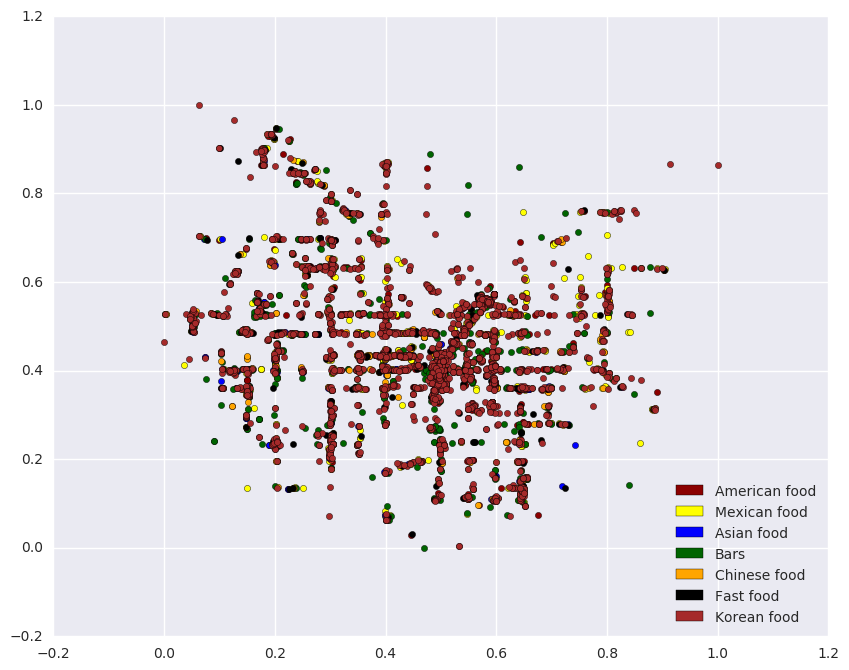

In [147]:
#plot heirarchical cluster
hcolors = ['darkred','yellow','blue','darkgreen','orange','black','brown']
hclasses = ['American food', 'Mexican food', 'Asian food', 'Bars','Chinese food', 'Fast food', 'Korean food']
plt.figure(figsize=(10, 8))
for j in range(len(hlocation.keys())): 
    plt.scatter([i[0] for i in hlocation[j]],[i[1] for i in hlocation[j]], marker = 'o', c = hcolors[j])
hcircles = []
for i in range(0,len(hcolors)):
    hcircles.append(mpatches.Circle((0,0),1,fc=hcolors[i]))
plt.legend(hcircles,hclasses,loc=4)
plt.show()

In [108]:
from sklearn import mixture
def sc_evaluate_gmm(X,max_clusters):
    s = np.zeros(max_clusters+1)
    s[0] = 0;
    s[1] = 0;
    for k in range(2,max_clusters+1):
        gmm = mixture.GMM(n_components=k, covariance_type='full')
        gmm.fit_predict(X)
        label = gmm.predict(X)
        s[k] = metrics.silhouette_score(X,label,metric='cosine')
    plt.plot(range(2,len(s)),s[2:])
    plt.xlabel('Number of clusters')
    plt.ylabel('Adjusted Rand Index')
    plt.show()

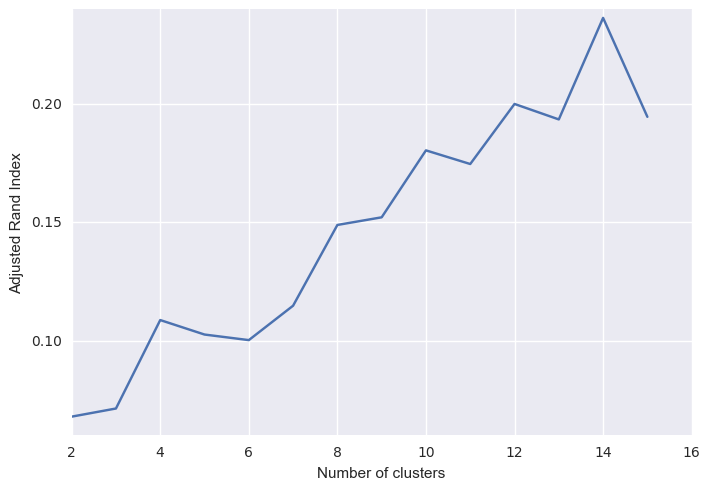

In [112]:
sc_evaluate_gmm(df_feature, 15)

In [114]:
#GMM clustering, choose # of cluster = 8, by the sc score
g=8
gmm = mixture.GMM(n_components=g, covariance_type='full')
gmm.fit(df_feature)
gmm_clustering = gmm.predict(df_feature)
gmm_clustering

array([0, 1, 0, ..., 7, 7, 7], dtype=int64)

In [137]:
gcluster = get_cluster(gmm_clustering, df_feature)
glocation = {}
for i in range(g):
    glocation[i] = []
    for j in range(len(gcluster[i])):
        glocation[i].append((gcluster[i][j][-1],gcluster[i][j][-2]))

In [141]:
#label the gmm clusters by hot terms
gcluster = get_cluster(gmm_clustering, df_feature)
gcenter = []
for i in range(g):
    gcenter.append(get_center(gcluster[i])[:100])
    gcenter[i] = np.array(gcenter[i]).argsort()[::-1]
for i in range(g):
    print("Cluster {}:".format(i))
    for j in gcenter[i][1:5]:
        print (' {}'.format(labels[j].index.tolist()))

Cluster 0:
 ['pizza', 'crust', 'delivery', 'pizzas', 'wings', 'pepperoni', 'slice', 'toppings', 'cheese', 'hut']
 ['italian', 'pasta', 'bbq', 'sauce', 'brisket', 'ribs', 'chicken', 'meatballs', 'lasagna', 'spaghetti']
 ['wings', 'ramen', 'korean', 'italian', 'roberto', 'pasta', 'burrito', 'asada', 'carne', 'chicken']
 ['drive', 'order', 'location', 'mcdonald', 'taco', 'lobster', 'subway', 'manager', 'wine', 'window']
Cluster 1:
 ['burger', 'fries', 'sushi', 'sandwich', 'order', 'burgers', 'subway', 'drive', 'chicken', 'location']
 ['dog', 'dogs', 'mexican', 'salsa', 'hot', 'chips', 'chili', 'chicago', 'enchiladas', 'margaritas']
 ['dog', 'taco', 'dogs', 'hot', 'tacos', 'fries', 'chicago', 'gyro', 'wings', 'del']
 ['buffet', 'bar', 'buffets', 'sandwich', 'pho', 'indian', 'subway', 'burger', 'legs', 'selection']
Cluster 2:
 ['sushi', 'tacos', 'taco', 'mexican', 'burrito', 'asada', 'rice', 'carne', 'salsa', 'pizza']
 ['dog', 'dogs', 'mexican', 'salsa', 'hot', 'chips', 'chili', 'chicago', 

Cluster 0: Italian food. 'pizza', 'pepperoni', 'italian','spaghetti'come together
Cluster 1: Fast food. 'burger', 'fries', 'hot dogs', 'sandwich' come together
Cluster 2: Mexican food. 'taco', 'burrito', 'carne asada', 'mexican'...
Cluster 3: Japanese food. 'sushi', 'sashimi', 'Japanese'
Cluster 4: American food: bbq, chicken, ribs, brisket, burger, fries, sandwiches...
Cluster 5: Chinese food: rice, noodles, soup
Cluster 6: Bars: 'bar', 'bartender', 'drinks'
Cluster 7: Hotel: 'buffet', 'eggs', 'coffee', 'pancake', 'toast' for breakfast, 'burger', 'fries', 'wings'...for lunch
and dinner, 'bar', 'drinks' for drinking

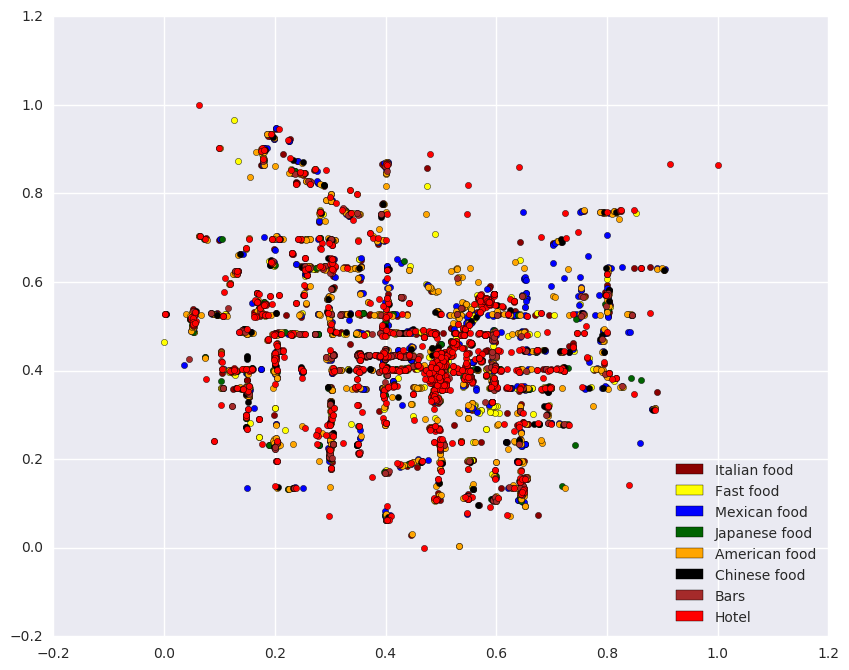

In [153]:
#plot gmm cluster
gcolors = ['darkred','yellow','blue','darkgreen','orange','black','brown', 'red']
gclasses = ['Italian food', 'Fast food','Mexican food', 'Japanese food', 'American food','Chinese food', 'Bars', 'Hotel']
plt.figure(figsize=(10, 8))
for j in range(len(glocation.keys())): 
    plt.scatter([i[0] for i in glocation[j]],[i[1] for i in glocation[j]], marker = 'o', c = gcolors[j])
gcircles = []
for i in range(0,len(gcolors)):
    gcircles.append(mpatches.Circle((0,0),1,fc=gcolors[i]))
plt.legend(gcircles,gclasses,loc=4)
plt.show()

----------

Compare your clusters with the results you obtained in Part 1. Use cluster comparison metrics, and also comment on which clustering appears (from your inspection of the clusters) to be more informative, and why. (15 pts)

In [164]:
model1 = kmeans_cluster
model2 = hierarchy_cluster
model3 = gmm_clustering
#previous model
vec = TfidfVectorizer(min_df = 0.01, max_df = 0.9)
m = vec.fit_transform(df_similarity)
df_previous = DataFrame(m.toarray())
df_previous = DataFrame(scale.fit_transform(df_previous.as_matrix()))
df_closeness = DataFrame(scale.fit_transform(df_closeness.as_matrix()))
df_previous[['latitude', 'longitude']] = df_closeness
#First 48 columns are vectorized categorical information, last two columns are location information
# df_previous

In [182]:
kmeans_previous = KMeans(n_clusters=7, init='k-means++', max_iter=100, n_init=1)
kmeans_previous = kmeans_previous.fit_predict(df_previous)
model4 = kmeans_previous

In [183]:
from scipy.cluster.hierarchy import dendrogram, linkage
Z_previous = linkage(df_previous, 'ward')
hierarchy_previous = fcluster(Z_previous, 7, criterion='maxclust')
model5 = hierarchy_previous

In [171]:
gmm_previous = mixture.GMM(n_components=7, covariance_type='full')
gmm_previous = gmm_previous.fit_predict(df_previous)
model6 = gmm_previous

In [180]:
from sklearn.metrics import silhouette_score
models = [model1, model2, model3]
ss = []
for model in models:
    ss.append(silhouette_score(df_feature, model))
ss

[0.086212545067864702, 0.099021643081366698, 0.090843013247272952]

In [184]:
previous_models = [model4, model5, model6]
ss_previous = []
for model in previous_models:
    ss_previous.append(silhouette_score(df_previous, model))
ss_previous

[0.14845798867762924, 0.19554958554077867, 0.1510287793102443]

Notice that previous models have larger silhouette score than new models, but intuitively the new models(especially the gmm model) are more informative. I guess the reason is that new models have more features than old models(102 vs 51). Therefore although new models have low silhouette score they give a better performance. There were lots of hot terms appear repeatedly in the old models because they just appear more frequently than others, as a result, although clustering metric shows that is a good cluster, it's not easy to assign labels to clusters. However, in our new models, by using PCA and SVD it's easy to get terms that indicate the uniqueness of a certain cluster, because reviews have much more terms than categories and people tend to evaluate spercific types of food when they write a review. Among all my clusters I believe model 3(gmm clustering on review) gives the most informative result. On the one hand, most clusters have unique key words that point out what this cluster about, such as 'spaghetti' in cluster 0, 'breakfast' in cluster 7, 'sashimi' in cluster 3...On the other hand, similar word groups together such as 'pasta', 'spaghetti', 'Italian' in cluster 0, 'taco', 'burrito', 'carne asada', 'mexican' in cluster 2, 'burger', 'fries' in cluster 1, sushi and sashimi in cluster 3...which makes sense intuitively. The kmeans clustering on categories also make sense. For example, in cluster 3 fast food burger sandwich come together as the top 4 hot terms, which indicate this cluster is about fast food clearly. But sometimes Clinese, Thai and Italian come together as the top 3 terms in a cluster, making it difficult to assign labels. In conclusion, I would like to use kmeans to cluster on categories, and gmm to cluster reviews. 